### Initial cleansing and analysis


In this notebook we will take the whole Quotebank dataset and filter with a set of keywords : "gun violence, mass shooting, firearm-related violence, firearm violence". The actual process of filtering needed a lot of ressources so we ran it individually on the provided Google Colab after a few modifications for our purpose. We ran the data for a year each time. In this process, we added a new column to the dataframe, with the keyword found as a string in the "Keyword" column. Then we created a final dataframe (which is the one we will use) by filtering and concatenating only the rows with a value in this new column. 

In parallel, we used the gun shootings events datasets "mass_shootings" and "accidents" from "https://www.gunviolencearchive.org/" to create a new dataset of relevant events. We chose to keep data from 2015 to 2019 because the data for 2020 was not available. However this is not a problem because during early 2020 some other global events took over the press and forced a lockdown in the US, this may have biased our analysis during this time period.

##### Filtering quotations related to gun violence
We queried the entire quotebank dataset in search of quotes containing any of a set of key words relating to guns and gun violence. This was done in google colab to avoid having download the entire data sets onto our hard drive and to execute the code in chunks (by year) simultaneously on all our computers. We also printed a sample of the values, the shape and the number of missing values, both for the preprocessed and processed data.
The code for the year 2019 is shown below as an example :

In [ ]:
!pip install tld
!pip install pandas==1.0.5 #have to downgrade to use on colab

In [ ]:
import pandas as pd
import bz2
import json

In [ ]:
def keyword(row):
  strings = row['quotation']
  keywords = ["gun violence","mass shooting","firearm-related violence","firearm violence"]
  keyword = [key for key in keywords if key.upper() in strings.upper()]
  return ','.join(keyword)

In [ ]:
#2019 all the chunk processing together
%load_ext google.colab.data_table
def process_chunk(chunk, i):
        print(f'Processing chunk with {len(chunk)} rows')
        print(chunk.columns)
        print(chunk.shape)
        print(len(chunk[chunk.isna().any(axis=1)]))
        print(chunk.sample(10))
        selected_columns = chunk[["speaker", "qids", "date", "quotation"]]
        filtered_chunk= selected_columns.copy()
        filtered_chunk['keyword'] = filtered_chunk.apply(keyword, axis=1)
        print(len(filtered_chunk[filtered_chunk.isna().any(axis=1)]))
        print(filtered_chunk.sample(5))
        print(filtered_chunk.shape)
        filtered_chunk.to_pickle("/content/drive/MyDrive/projectada/processed_dfs/2019/" + str(i) +  "chunk_with_keyword.pkl", compression='infer', protocol=4)

i = 0
df_reader = pd.read_json('/content/drive/MyDrive/datasets_ADA/Quotebank/quotes-2019.json.bz2', lines=True, compression='bz2', chunksize=1500000)
for chunk in df_reader:
  i += 1
  process_chunk(chunk, i)

The next step was to create the final dataframe by filtering out the rows which didn't contain a keyword. We also filtered out any quote with undetermined speaker ("None" in the data). Based on our observations of the data, it appears that quotes with no attributed speakers are in most cases unintelligible. Since our work will be based on a sentimental analysis, keeping those quotes seemed useless. This filtering was done with the following code, which we also previously ran on Google Collab:

In [ ]:
from os import listdir, getcwd

#also save include the rows with unkown rows
DATA_PATH = '/content/drive/MyDrive/projectada/processed_dfs/' 

def process_data(path, year, list_dfs):
  while year < 2020:
    for file in listdir(path + str(year) + '/'):
      small_df=pd.read_pickle(DATA_PATH + str(year) + '/' + file, compression='infer')
      filtered_small_df = small_df.query("keyword == 'gun violence' | keyword == 'mass shooting' | keyword == 'firearm-related violence' | keyword == 'firearm violence'")
      list_dfs.append(filtered_small_df)
    year += 1
  return list_dfs

list_dfs = []
df = pd.concat(process_data(DATA_PATH, 2015, list_dfs), ignore_index=True)

         

In [65]:
print(df.sample(10))
print(df.shape) #check how big is the dataframe
print(len(df[df.isna().any(axis=1)])) # check for any missing values
print(df['speaker'].eq('None').sum()) #count how many missing speakers in our dataframe, we see that we have about 20k assigned speakers
print(df['speaker'].nunique()) # count how many unique speakers (counting also None)

#we want to count how many words in each quotation, first we lower and remove number and symbol
df['quotation'] = df['quotation'].apply(lambda x: x.lower())
df['quotation'] = df['quotation'].replace('\d+', '', regex = True)
df['quotation'] = df['quotation'].replace('[^\w\s\+]', '', regex = True)
df['Words count'] = df['quotation'].apply(lambda x: len(str(x).split(' ')))



                        speaker         qids  ...        keyword Words count
17817             Mark Hastings  [Q27058474]  ...  mass shooting          43
7607                Seth Meyers     [Q14536]  ...   gun violence          15
11237             Emma González  [Q49560460]  ...   gun violence           8
1616                       None           []  ...   gun violence           7
26597                Kris Brown   [Q1619393]  ...   gun violence          32
30002           Fred Guttenberg  [Q50380052]  ...   gun violence          28
201             Hillary Clinton      [Q6294]  ...   gun violence          31
3180               Suzanna Hupp   [Q7650729]  ...  mass shooting          12
27385  Alexandria Ocasio-Cortez  [Q55223040]  ...  mass shooting          18
3487            Nydia Velazquez    [Q434890]  ...   gun violence          15

[10 rows x 6 columns]
(30677, 6)
0
10198
5961


In [67]:
avg_word_counts_par_speaker = df.groupby(['speaker'])[['Words count']].mean().reset_index()
print(avg_word_counts_par_speaker.shape)
avg_word_counts_par_speaker = avg_word_counts_par_speaker.sort_values('Words count', ascending=False)
avg_word_counts_par_speaker
# we see that we have some speaker with very high avg word counts, let's dig deeper

(5961, 2)


,speaker,Words count
1943,Freddie Hamilton,450.0
3727,Maria Cantwell,429.0
4731,Rebecca Solnit,416.0
1639,Donovan Mitchell,318.0
3768,Mark Greene,314.0
...,...,...
308,Anthony Beale,4.0
5674,Tom Deininger,4.0
917,Chesa Boudin,4.0
1764,Eli Saslow,4.0


speaker        12
Words count    12
dtype: int64
speaker        0
Words count    0
dtype: int64
speaker        0
Words count    0
dtype: int64
speaker        13
Words count    13
dtype: int64


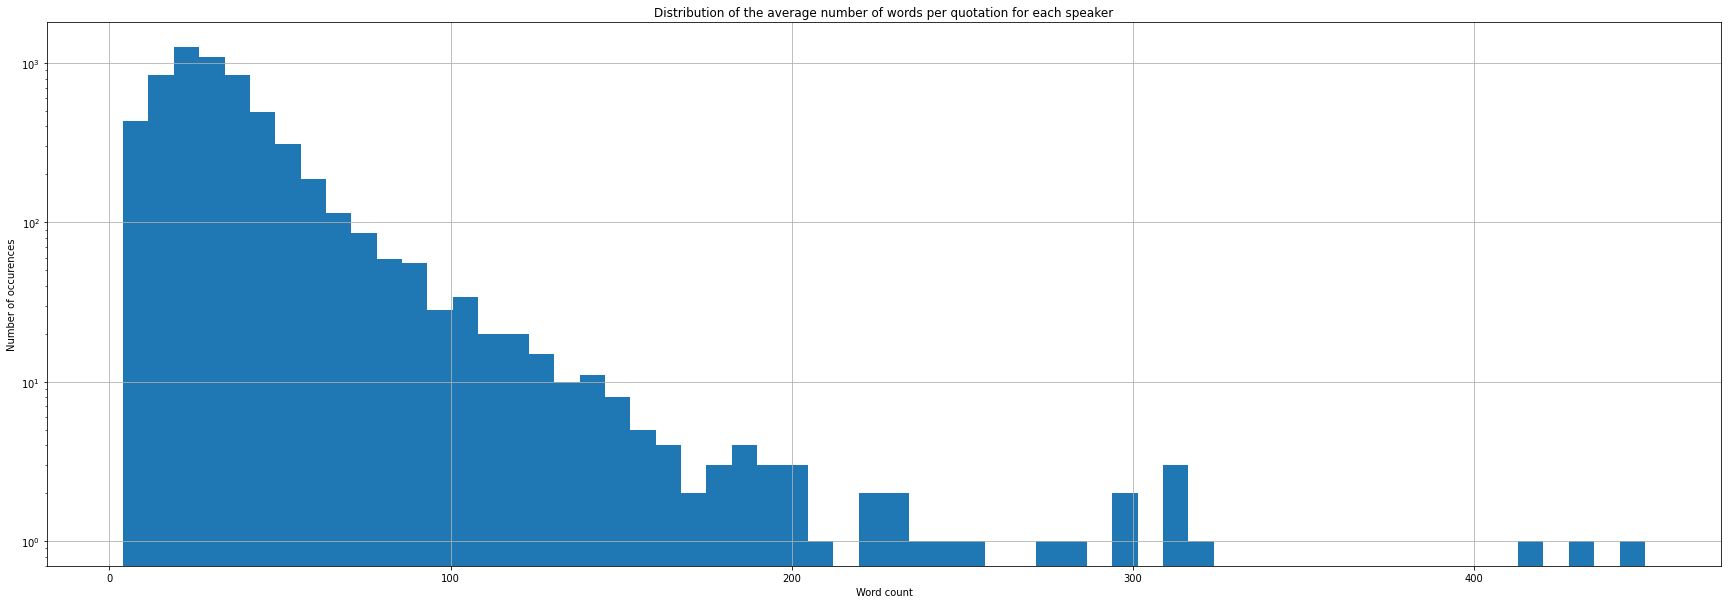

In [104]:
ax = avg_word_counts_par_speaker['Words count'].hist(log=True, bins=60, figsize=[30,10]);
ax.set_ylabel("Number of occurences");
ax.set_xlabel("Word count");
ax.set_title("Distribution of the average number of words per quotation for each speaker")

print(avg_word_counts_par_speaker[avg_word_counts_par_speaker['Words count'] > 250].count())
print(avg_word_counts_par_speaker[avg_word_counts_par_speaker['Words count'] < 3].count())
print(avg_word_counts_par_speaker[avg_word_counts_par_speaker['Words count'] < 4].count())
print(avg_word_counts_par_speaker[avg_word_counts_par_speaker['Words count'] < 5].count())
#we observe that few speakers have higher than 250 words on average par quotation, specifically 12 and below 3 and 4 words no instances

We can see that most speakers have a low word counts, but a few of them have a very large number of words. We also obserev that there are no speakers with less than 4 words, which is good because we are looking for phrases and not random words.  

In [84]:
total_sum_word_counts_par_speaker = df.groupby(['speaker'])[['Words count']].sum().reset_index()
print(total_sum_word_counts_par_speaker.shape)
total_sum_word_counts_par_speaker = total_sum_word_counts_par_speaker.sort_values('Words count', ascending=False)
total_sum_word_counts_par_speaker
#

(5961, 2)


,speaker,Words count
4367,None,330334
4628,President Barack Obama,11475
4281,Nancy Pelosi,9548
4636,President Obama,9367
2209,Hillary Clinton,8348
...,...,...
5488,Susana Martinez,4
655,Brian Dugan,4
1966,Garret Graves,4
5674,Tom Deininger,4


Note: 
We observe that some speakers may be present multiple times under slightly different name, for example "President Barack Obama" or "President Obama". This issue does not need to be treated here, since if and when we will study individual relevant speakers, we will only search part of their name, in this case "Obama" will suffice to detect any case of quotations from him. 

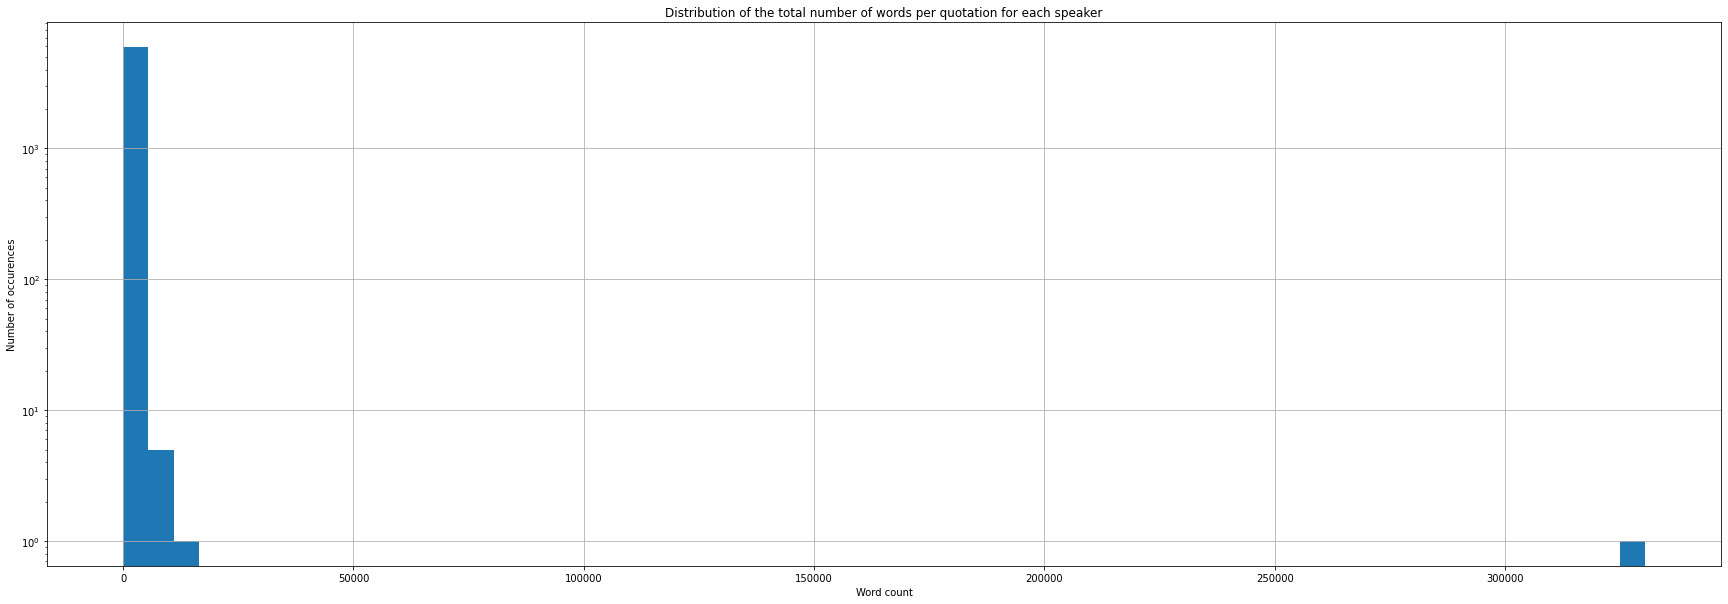

In [108]:
ax = total_sum_word_counts_par_speaker['Words count'].hist(log=True, bins=60, figsize=[30,10]);
ax.set_ylabel("Number of occurences");
ax.set_xlabel("Word count");
ax.set_title("Distribution of the total number of words per quotation for each speaker");

We observe in this graph that the unknown speakers make up for most of the total count of words, which is another argument of why we chose to remove them, because if those quotations are misleading it would totally ruin our analysis.

In [101]:
desc = df.groupby(['speaker'])[['Words count']].describe().reset_index()
desc

speaker Words count             ...                   
                                   count       mean  ...   50%    75%   max
0                  21 Savage         1.0  22.000000  ...  22.0  22.00  22.0
1                   A. Clark         6.0  35.833333  ...  32.5  48.75  61.0
2                  A. Harris         1.0  34.000000  ...  34.0  34.00  34.0
3                    A. King         1.0  71.000000  ...  71.0  71.00  71.0
4                   AJ Perez         1.0  19.000000  ...  19.0  19.00  19.0
...                      ...         ...        ...  ...   ...    ...   ...
5956  president Barack Obama        10.0  32.000000  ...  34.5  40.00  43.0
5957               ron Smith         1.0   7.000000  ...   7.0   7.00   7.0
5958           stacey newman         1.0  27.000000  ...  27.0  27.00  27.0
5959               tim kaine         1.0  36.000000  ...  36.0  36.00  36.0
5960                you long         1.0   9.000000  ...   9.0   9.00   9.0

[5961 rows x 9 columns]

In [106]:
DATA_PATH = '/content/drive/MyDrive/projectada/processed_dfs/' 
#do the same but removing all the rows with unkown speakers
def process_data(path, year, list_dfs):
  while year < 2020:
    for file in listdir(path + str(year) + '/'):
      small_df=pd.read_pickle(DATA_PATH + str(year) + '/' + file, compression='infer')
      filtered_small_df = small_df.query("(keyword == 'gun violence' | keyword == 'mass shooting' | keyword == 'firearm-related violence' | keyword == 'firearm violence') & speaker != 'None'")
      list_dfs.append(filtered_small_df)
    year += 1
  return list_dfs

list_dfs = []
data = pd.concat(process_data(DATA_PATH, 2015, list_dfs), ignore_index=True)

In [107]:
print(data.sample(10))
print(data.shape) #check how big is the dataframe
print(len(data[data.isna().any(axis=1)])) # check for any missing values
print(data['speaker'].eq('None').sum()) #count how many missing speakers in our dataframe, we see that we have about 20k assigned speakers
print(data['speaker'].nunique()) # count how many unique speakers

#we want to count how many words in each quotation, first we lower and remove number and symbol
data['quotation'] = data['quotation'].apply(lambda x: x.lower())
data['quotation'] = data['quotation'].replace('\d+', '', regex = True)
data['quotation'] = data['quotation'].replace('[^\w\s\+]', '', regex = True)
data['Words count'] = data['quotation'].apply(lambda x: len(str(x).split(' ')))



                      speaker  ...        keyword
12920               Bob Krist  ...   gun violence
7794       Gabrielle Giffords  ...   gun violence
14184          Julie Morrison  ...  mass shooting
19785              Eric Adams  ...   gun violence
15650             Chris Evans  ...   gun violence
15499            Sam Liccardo  ...   gun violence
1315           Marlon Kimpson  ...   gun violence
11346  Michelle Lujan Grisham  ...   gun violence
1980               Chuck Todd  ...   gun violence
13545              Ken Burton  ...   gun violence

[10 rows x 5 columns]
(20479, 5)
0
0
5960


In [109]:
avg_word_counts_par_speaker = data.groupby(['speaker'])[['Words count']].mean().reset_index()
print(avg_word_counts_par_speaker.shape)
avg_word_counts_par_speaker = avg_word_counts_par_speaker.sort_values('Words count', ascending=False)
avg_word_counts_par_speaker

(5960, 2)


,speaker,Words count
1943,Freddie Hamilton,450.0
3727,Maria Cantwell,429.0
4730,Rebecca Solnit,416.0
1639,Donovan Mitchell,318.0
3768,Mark Greene,314.0
...,...,...
308,Anthony Beale,4.0
5673,Tom Deininger,4.0
917,Chesa Boudin,4.0
1764,Eli Saslow,4.0


speaker        12
Words count    12
dtype: int64
speaker        0
Words count    0
dtype: int64
speaker        0
Words count    0
dtype: int64
speaker        13
Words count    13
dtype: int64


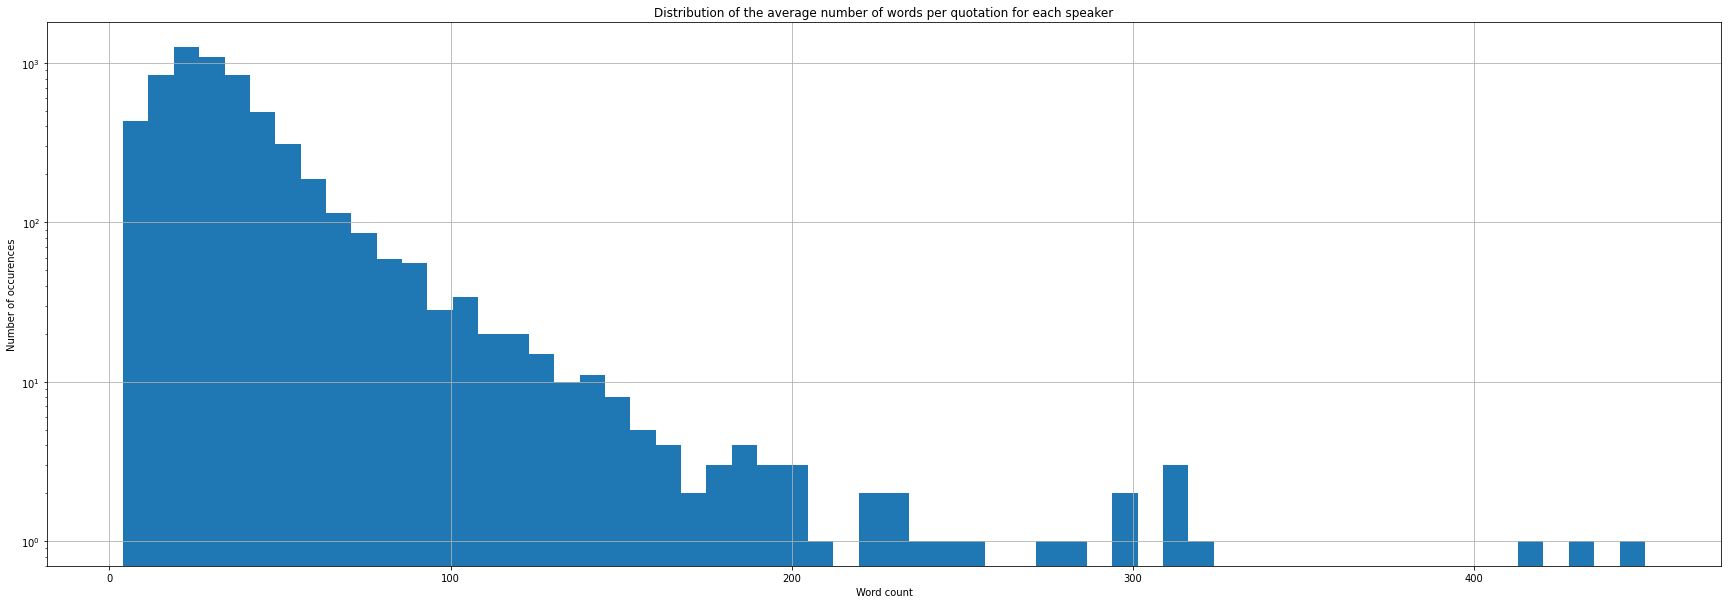

In [110]:
ax = avg_word_counts_par_speaker['Words count'].hist(log=True, bins=60, figsize=[30,10]);
ax.set_ylabel("Number of occurences");
ax.set_xlabel("Word count");
ax.set_title("Distribution of the average number of words per quotation for each speaker");

print(avg_word_counts_par_speaker[avg_word_counts_par_speaker['Words count'] > 250].count())
print(avg_word_counts_par_speaker[avg_word_counts_par_speaker['Words count'] < 3].count())
print(avg_word_counts_par_speaker[avg_word_counts_par_speaker['Words count'] < 4].count())
print(avg_word_counts_par_speaker[avg_word_counts_par_speaker['Words count'] < 5].count())
#we observe that few speakers have higher than 250 words on average par quotation, specifically 12 and below 3 and 4 words no instances

In [111]:
total_sum_word_counts_par_speaker = data.groupby(['speaker'])[['Words count']].sum().reset_index()
print(total_sum_word_counts_par_speaker.shape)
total_sum_word_counts_par_speaker = total_sum_word_counts_par_speaker.sort_values('Words count', ascending=False)
total_sum_word_counts_par_speaker
#

(5960, 2)


,speaker,Words count
4627,President Barack Obama,11475
4281,Nancy Pelosi,9548
4635,President Obama,9367
2209,Hillary Clinton,8348
970,Chris Murphy,6820
...,...,...
5487,Susana Martinez,4
655,Brian Dugan,4
1966,Garret Graves,4
5673,Tom Deininger,4


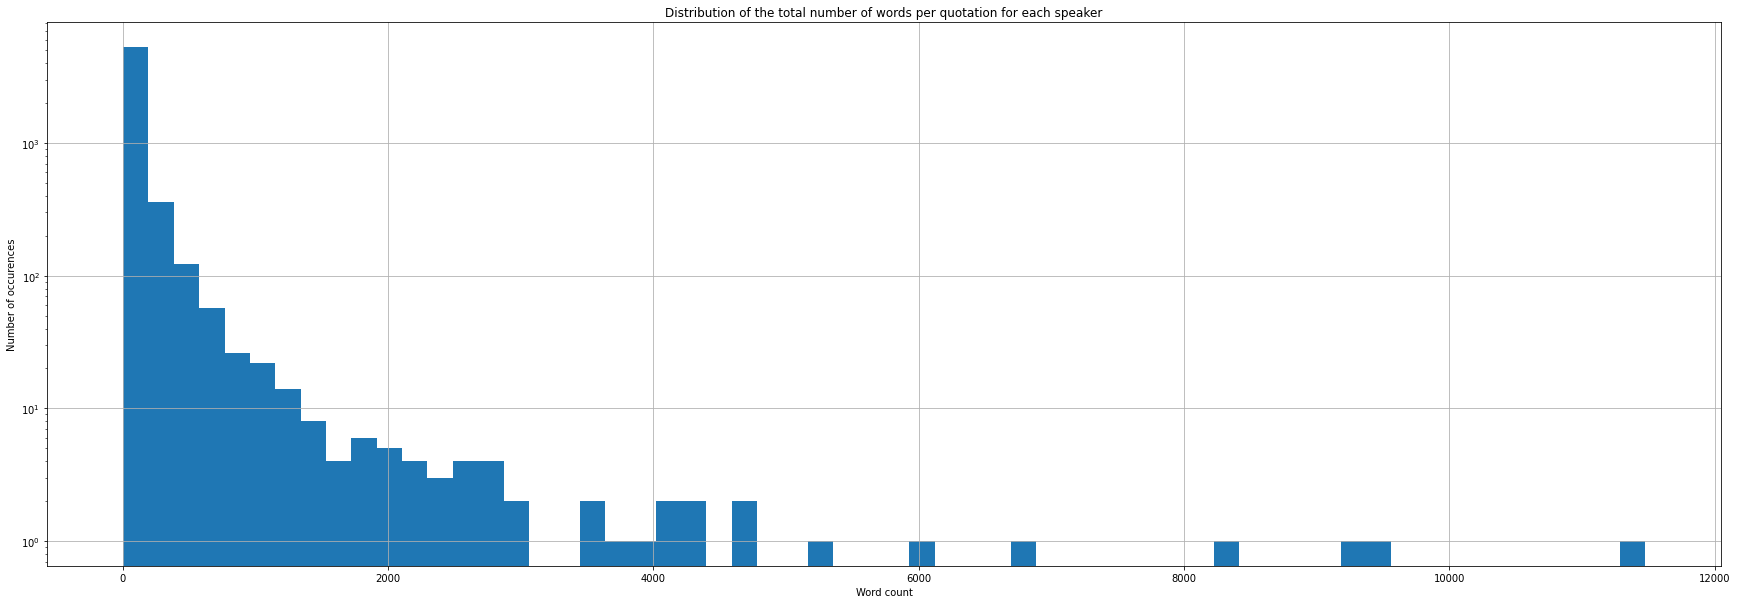

In [112]:
ax = total_sum_word_counts_par_speaker['Words count'].hist(log=True, bins=60, figsize=[30,10]);
ax.set_ylabel("Number of occurences");
ax.set_xlabel("Word count");
ax.set_title("Distribution of the total number of words per quotation for each speaker");

In [ ]:
#save into pickles in particular files
df.to_pickle("/content/drive/MyDrive/projectada/processed_dfs/2020/" + str(i) + "chunk_with_keyword.pkl", compression='infer', protocol=4)

In the end from the original 336 instances, about 90 are without speakers.

For the mass shootings dataset, we first loaded all the years from the website and merged them in a single one. 
As of now, we will keep all the data as our first wish is to see whether events actually have an effect on the amount of quotes. For further analysis, we might select a subset of the data to focus on particular events. See the code below for initial loading, concatening and analysis of the guns dataset.

In [ ]:
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np

In [ ]:
DATA_FOLDER = ''

MASS_SHOOTINGS_15 = DATA_FOLDER+"massshootings15.csv"
MASS_SHOOTINGS_16 = DATA_FOLDER+"massshootings16.csv"
MASS_SHOOTINGS_17 = DATA_FOLDER+"massshootings17.csv"
MASS_SHOOTINGS_18 = DATA_FOLDER+"massshootings18.csv"
MASS_SHOOTINGS_19 = DATA_FOLDER+"massshootings19.csv"
ACCIDENTS = DATA_FOLDER+"accidents.csv"

In [ ]:
mass_shootings_15 = pd.read_csv(MASS_SHOOTINGS_15)
mass_shootings_16 = pd.read_csv(MASS_SHOOTINGS_16)
mass_shootings_17 = pd.read_csv(MASS_SHOOTINGS_17)
mass_shootings_18 = pd.read_csv(MASS_SHOOTINGS_18)
mass_shootings_19 = pd.read_csv(MASS_SHOOTINGS_19)
accidents = pd.read_csv(ACCIDENTS)

In [ ]:
mass_shootings=pd.concat([mass_shootings_15, mass_shootings_16, mass_shootings_17, mass_shootings_18,
                          mass_shootings_19], ignore_index=True)

In [ ]:
mass_shootings = mass_shootings.drop(columns=['State', 'City Or County', 'Address', 'Operations'])
mass_shootings['Category']='Mass Shooting'
mass_shootings['Incident Date'] = pd.to_datetime(mass_shootings['Incident Date'])
accidents = accidents.drop(columns=['State', 'City Or County', 'Address', 'Operations'])
accidents = accidents[~accidents['Incident Date'].str.contains("2021")]
accidents = accidents[~accidents['Incident Date'].str.contains("2020")]
accidents['Category']='Accident'
accidents['Incident Date'] = pd.to_datetime(accidents['Incident Date'])

In [ ]:
mass_shootings.sort_values('# Killed', ascending=False).head()

,Incident ID,Incident Date,# Killed,# Injured,Category
788,946496,2017-10-01,59,441,Mass Shooting
581,577157,2016-06-12,50,53,Mass Shooting
754,980577,2017-11-05,27,20,Mass Shooting
1574,1466705,2019-08-03,23,23,Mass Shooting
1372,1049217,2018-02-14,17,17,Mass Shooting


In [ ]:
accidents.sort_values('# Killed', ascending=False).head()

,Incident ID,Incident Date,# Killed,# Injured,Category
1058,1564937,2019-12-05,4,1,Accident
1400,1323697,2019-02-09,2,0,Accident
1985,926038,2017-09-02,2,0,Accident
1825,1031159,2018-01-19,2,0,Accident
1445,1289271,2018-12-31,2,0,Accident


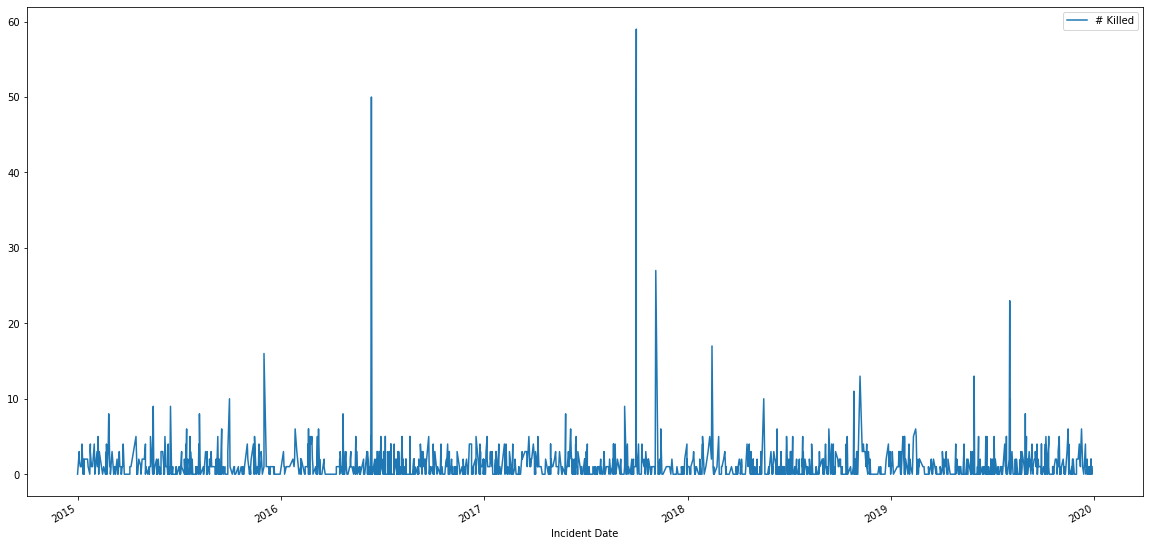

In [ ]:
mass_shootings.plot(x='Incident Date', y='# Killed', figsize=(20,10));